# Format the Hyades data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 40,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
hy1 = pd.read_csv("data/hyades_douglas.csv", skiprows=77)
hy1.head()

,[RSP2011],HIP,RAJ2000,DEJ2000,2MASS,EPIC,Kpmag,Mass,Bin,Ap,...,I99.9,Q,mPer,use,K2Per,K2Pw,Amp,Ng,Bl,Lit
0,64,,03 34 10.5,+22 04 21.2,03341053+2204213,210942999,13.68,0.17,2,4.0,...,0.0094,0,N,corr,1.8088,0.8608,0.008264,Y,N,1
1,,,03 40 45.8,+17 34 47.7,03404581+1734477,210643507,16.64,0.13,0,3.0,...,0.0091,2,N,corr,,,0.020290,N,N,0
2,75,,03 42 04.4,+16 25 18.3,03420441+1625183,210563410,15.13,0.18,0,2.0,...,0.0083,2,N,corr,,,0.158637,Y,Y,0
3,78,,03 43 47.0,+20 51 36.4,03434706+2051363,210865372,13.38,0.32,0,2.5,...,0.0091,0,N,corr,12.3168,0.6320,0.014581,Y,N,0
4,80,,03 46 59.5,+15 24 16.8,03465952+1524170,210499476,14.16,0.18,2,4.0,...,0.0098,0,N,corr,0.8584,0.7517,0.005815,N,N,1


Load the catalog of confirmed binaries.

In [3]:
bi = pd.read_csv("data/hyades_binaries.csv", skiprows=53)
epics, binary = [], []
for i in range(len(bi)):
    try:
        epics.append(int(bi.EPIC.values[i]))
        binary.append(bi["Conf?"].values[i])
    except ValueError:
        pass
    
bi1 = pd.DataFrame(dict({"EPIC": np.array(epics), "Binary": np.array(binary)}))
hy = pd.merge(hy1, bi1, on="EPIC", how="outer")

Convert RA and dec to degrees and reformat rotation periods.

In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord

ra, dec = [np.zeros(len(hy)) for i in range(2)]
for i in range(len(hy)):
    radec = "{0} {1}".format(hy.RAJ2000[i], hy.DEJ2000[i])
    c = SkyCoord(radec, unit=(u.hourangle, u.deg))
    ra[i] = c.ra.deg
    dec[i] = c.dec.deg
    
hy["RA_deg"] = ra
hy["DE_deg"] = dec

# print(hy.K2Per.values)
prots = np.zeros(len(hy))
for i, p in enumerate(hy.K2Per.values):
    try:
        prots[i] = float(p)
    except ValueError:
        pass
    
hy["prot"] = np.array(prots)
hy = hy.iloc[hy.prot.values > 0.]

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [5]:
with fits.open('data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)

In [6]:
c4_mask = bedell.k2_campaign_str.values == "4"

Calculate uncertainties on Gaia magnitudes.

In [7]:
def color_err(c):
    c_err = np.zeros(len(c))
    bright = c < 13
    medium = (13 < c) * (c < 17)
    faint = 17 <= c
    c_err[bright] = np.ones(len(c_err[bright]))*.002
    c_err[medium] = np.ones(len(c_err[medium]))*.01
    c_err[faint] = np.ones(len(c_err[faint]))*.2
    return c_err


def photometric_noise(G, bp, rp):
    G_err = np.zeros(len(G))
    bright = G < 13
    medium = (13 < G) * (G < 17)
    faint = 17 <= G
    G_err[bright] = np.ones(len(G_err[bright]))*.0003
    G_err[medium] = np.ones(len(G_err[medium]))*.002
    G_err[faint] = np.ones(len(G_err[faint]))*.01

    bp_err = color_err(bp)
    rp_err = color_err(rp)
    
    parallax_err = np.zeros(len(G))
    bright = G < 15
    medium = (15 < G) * (G < 17)
    faint = (17 < G) * (G < 20)
    ultra_faint = 21 <= G
    parallax_err[bright] = .03  # milliarcseconds
    parallax_err[medium] = .1
    parallax_err[faint] = .7
    parallax_err[ultra_faint] = 2
    
    return G_err, bp_err, rp_err, parallax_err

In [8]:
G_err, bp_err, rp_err, _ = photometric_noise(bedell.phot_g_mean_mag.values[c4_mask],
                                             bedell.phot_bp_mean_mag.values[c4_mask],
                                             bedell.phot_rp_mean_mag.values[c4_mask])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


Save mini dataframe as csv file.

In [9]:
c4 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c4_mask], 
                        "EPIC": bedell.epic_number.values[c4_mask], 
                        "ra": bedell.ra.values[c4_mask], 
                        "dec": bedell.dec.values[c4_mask], 
                        "G": bedell.phot_g_mean_mag.values[c4_mask],
                        "G_err": G_err,
                        "bp": bedell.phot_bp_mean_mag.values[c4_mask],
                        "bp_err": bp_err,
                        "rp": bedell.phot_rp_mean_mag.values[c4_mask],
                        "rp_err": rp_err,
                        "parallax": bedell.parallax.values[c4_mask],
                        "parallax_err": bedell.parallax_error.values[c4_mask],
                       }))
c4.to_csv("data/c4_gaia.csv")

Text(0, 0.5, '$\\mathrm{Dec}$')

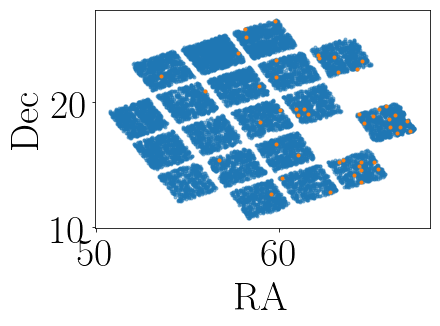

In [10]:
plt.plot(c4.ra, c4.dec, ".", alpha=.5)
plt.plot(hy.RA_deg, hy.DE_deg, ".")
plt.xlabel("$\mathrm{RA}$")
plt.ylabel("$\mathrm{Dec}$")

Just plot the crossmatched stars.

In [11]:
df = pd.merge(c4, hy, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)

Text(0, 0.5, '$\\mathrm{Dec}$')

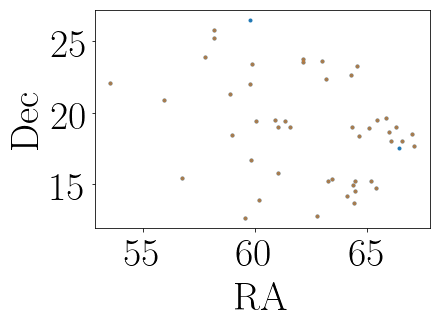

In [12]:
plt.plot(hy.RA_deg, hy.DE_deg, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("$\mathrm{RA}$")
plt.ylabel("$\mathrm{Dec}$")

/Users/rangus/projects/stardate/stardate/lhf.py:66: RuntimeWarning: divide by zero encountered in log10
  log10_bprp = np.log10(bprp)


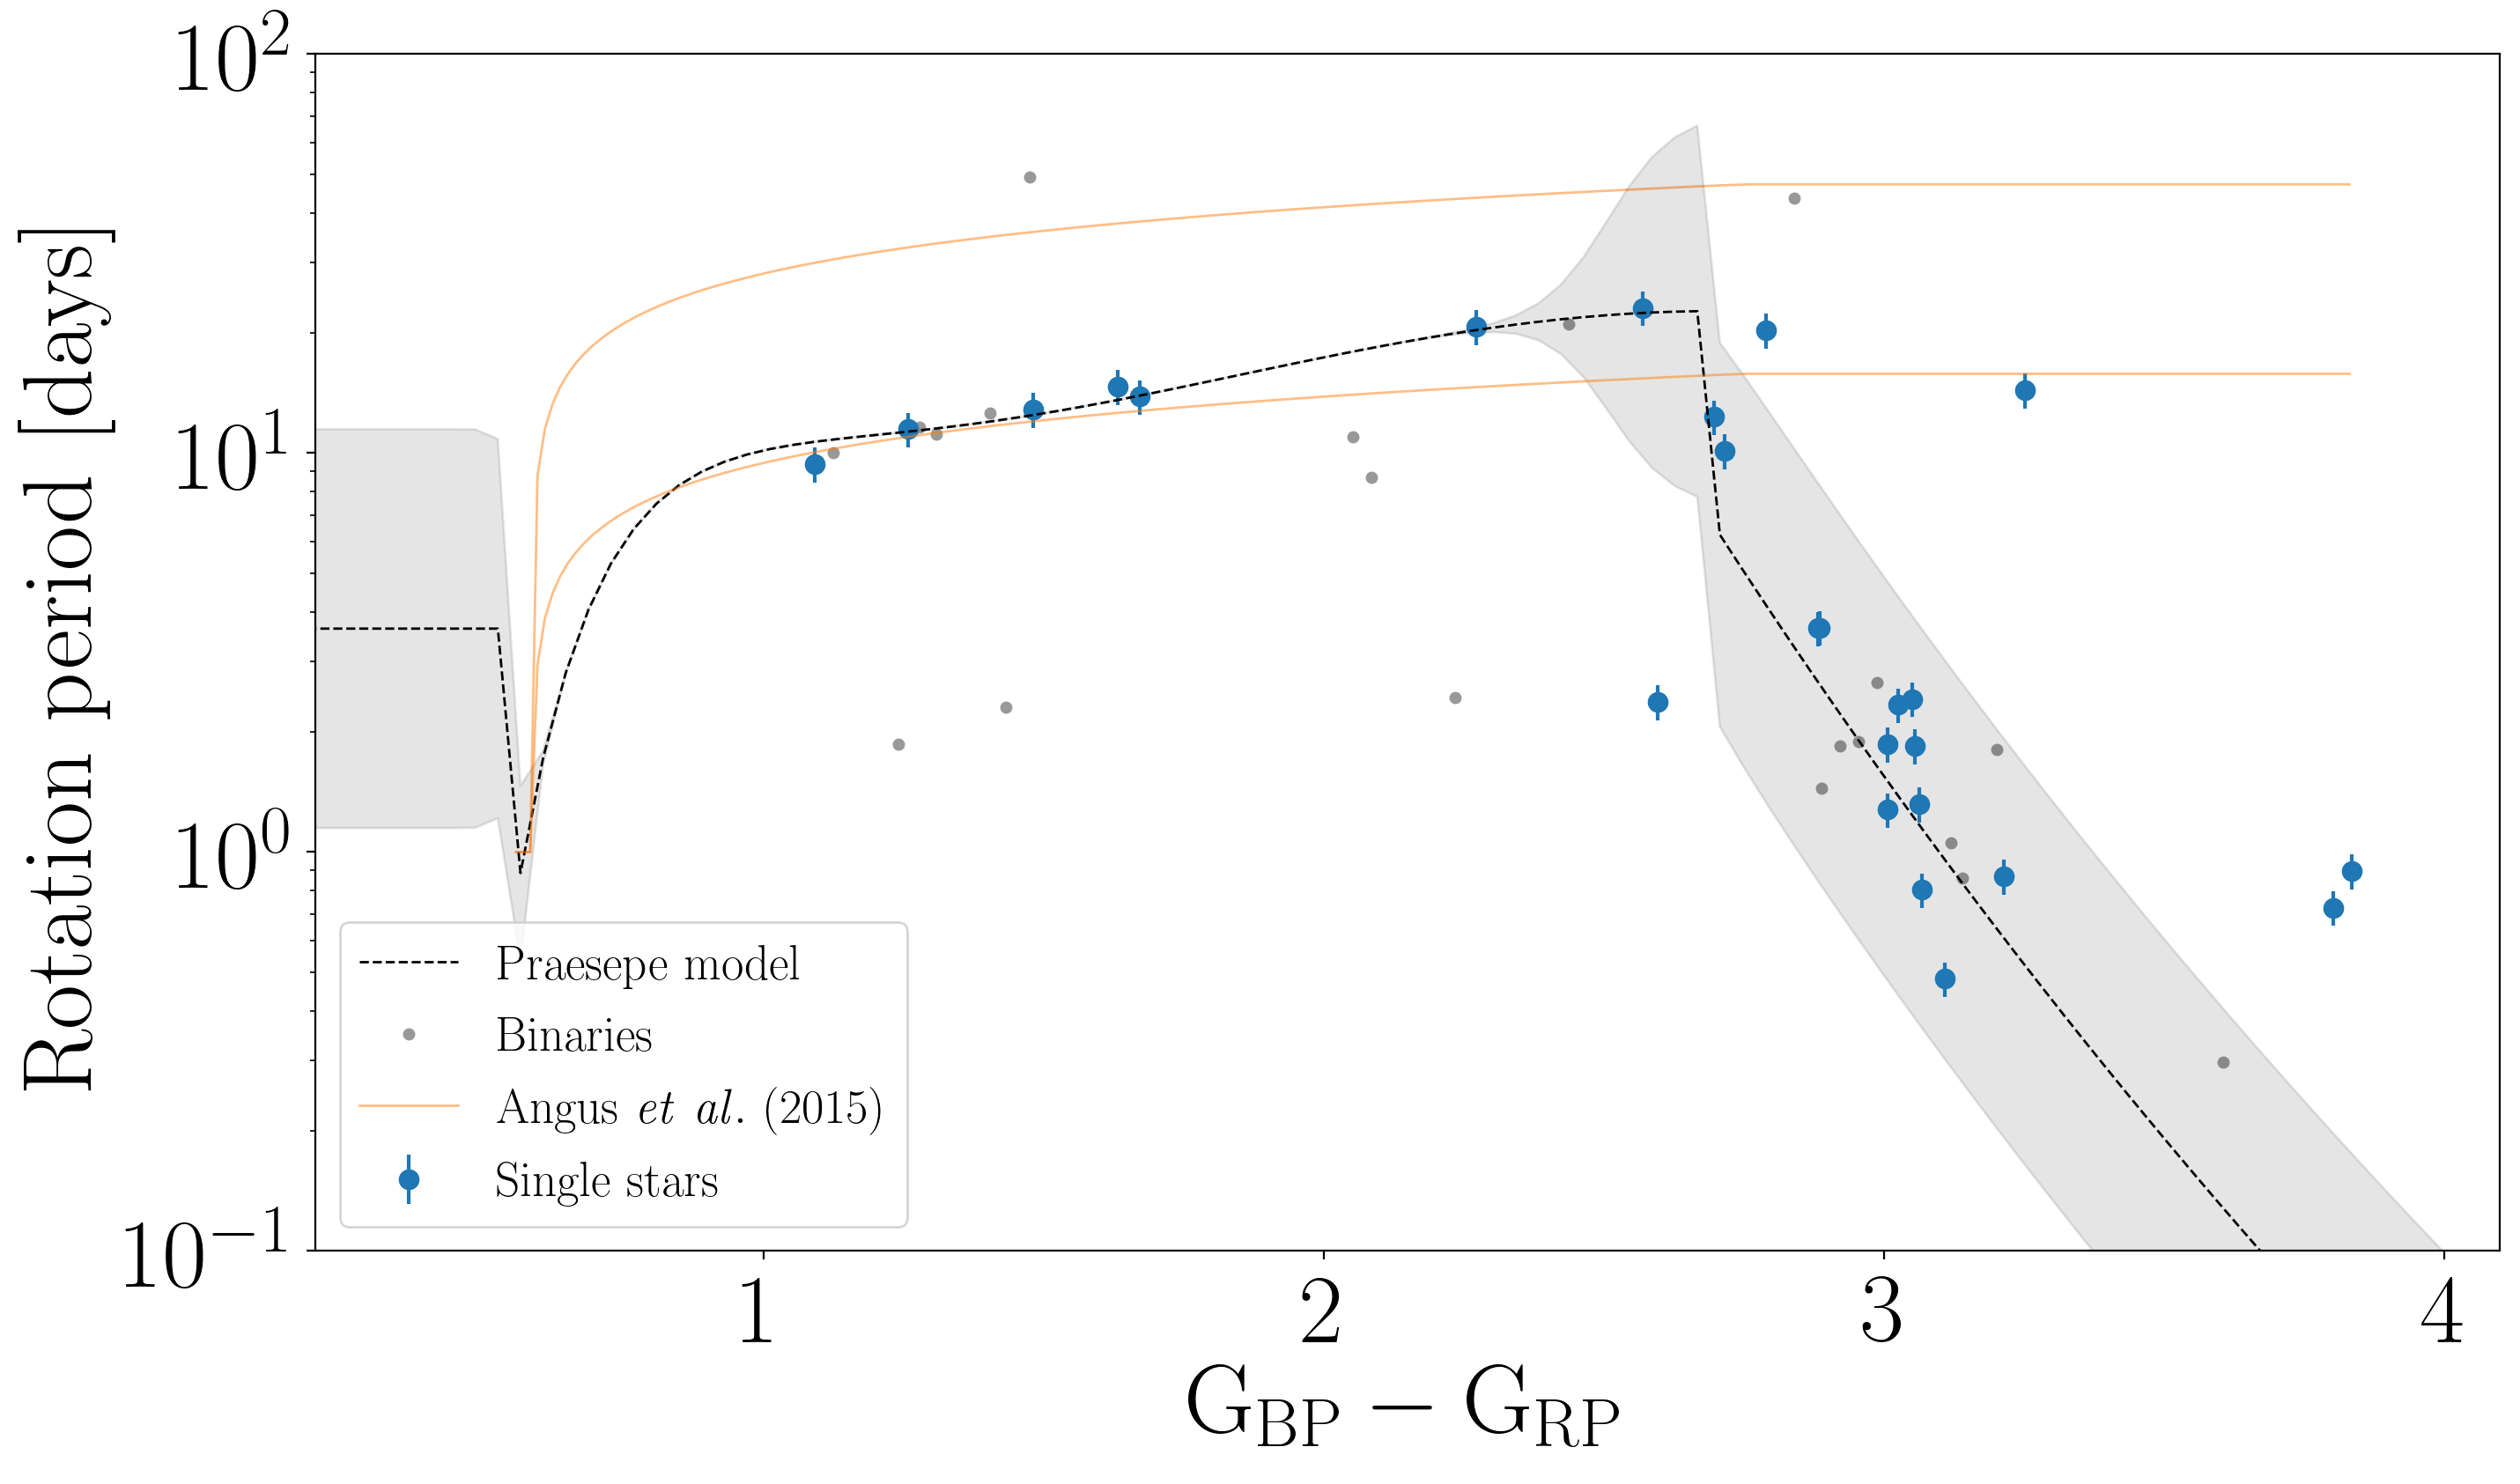

In [23]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import stardate.lhf as sdl

xs = np.linspace(0, 4, 100)
log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(3)]
for i, _x in enumerate(xs):
    log_periods_praesepe[i] = sdl.gyro_model_praesepe(np.log10(700*1e6), _x)
    log_periods_sun[i] = sdl.gyro_model_praesepe(np.log10(4.56*1e9), _x)
    log_sigs[i] = sdl.sigma(355, 9, 0., _x, model="praesepe")
    
plt.figure(figsize=(16, 9), dpi=200)

plt.plot(xs, 10**log_periods_praesepe, color="k", lw=1, ls="--", zorder=3, ms=35, rasterized=True,
        label="$\mathrm{Praesepe~model}$")
plt.fill_between(xs, 10**(log_periods_praesepe - log_sigs), 
                 10**(log_periods_praesepe + log_sigs), color="k", alpha=.1, rasterized=True)
# plt.plot(xs, 10**log_periods_sun, color="k", lw=1, ls="--", zorder=0, rasterized=True)
# plt.fill_between(xs, 10**(log_periods_sun - log_sigs), 
#                  10**(log_periods_sun + log_sigs), color="k", alpha=.1, rasterized=True)

binary = df.Binary.values == "Y"
plt.errorbar(df.bp[~binary] - df.rp[~binary], df.prot[~binary], 
             yerr=.1*df.prot[~binary], fmt=".", ms=15, zorder=1,
             label="$\mathrm{Single~stars}$")

# Plot confirmed binarys
plt.plot(df.bp[binary] - df.rp[binary], df.prot[binary], ".", color=".6", ms=8, zorder=0,
         label="$\mathrm{Binaries}$")

from tools import bprp_2_bv
import stardate.lhf as sdl

# Plot Angus (2015) model.
xs = np.linspace(-.15, .6, 100)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(625*1e6), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(355, 9, 0, bv[i])

plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C1", lw=1, zorder=3, ms=35, rasterized=True,
        alpha=.5)
plt.plot(10**xs-.15, 10**log_periods_sun, color="C1", lw=1, zorder=0, rasterized=True,
         label="$\mathrm{Angus~{\it et~al.}~(2015)}$", alpha=.5)


plt.yscale("log")
plt.ylim(.1, 100)
plt.xlim(.2, 4.1)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.legend()

In [14]:
df.to_csv("data/hyades.csv")
df_singles = df.iloc[~binary]
df_singles.to_csv("data/hyades_single.csv")

In [169]:
import stardate as sd
i = np.arange(len(df_singles))[df_singles.bp.values
                               - df_singles.rp.values
                               == min(df_singles.bp.values - df_singles.rp.values)][0]
print(df_singles.prot.values[i])
print(i)

9.3908
22


In [171]:
iso_params = {"G": (df_singles.G.values[i], df_singles.G_err.values[i]),
              "BP": (df_singles.bp.values[i], df_singles.bp_err.values[i]),
              "RP": (df_singles.rp.values[i], df_singles.rp_err.values[i]),
              "parallax": (df_singles.parallax.values[i], df_singles.parallax_err.values[i]),
              "maxAV": .1}

inits = [330, 8.896, .07, np.log(45), 0.]
star = sd.Star(iso_params, prot=df_singles.prot.values[i], 
               prot_err=df_singles.prot.values[i]*.1, filename="hyades_test")

In [172]:
from stardate.lhf import lnprob
from isochrones import StarModel, get_ichrone
bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = get_ichrone("mist", bands=bands)

mod = StarModel(mist, **iso_params)
args = [mod, df.prot.values[i], df.prot.values[i]*.1, False, True, "praesepe"]
print(lnprob(inits, *args))

(-3151247.894199885, -23.580744292034982)


In [173]:
star.fit(max_n=10000, inits=inits, model="angus15");

100%|██████████| 10000/10000 [01:25<00:00, 117.57it/s]


(2400, 5)


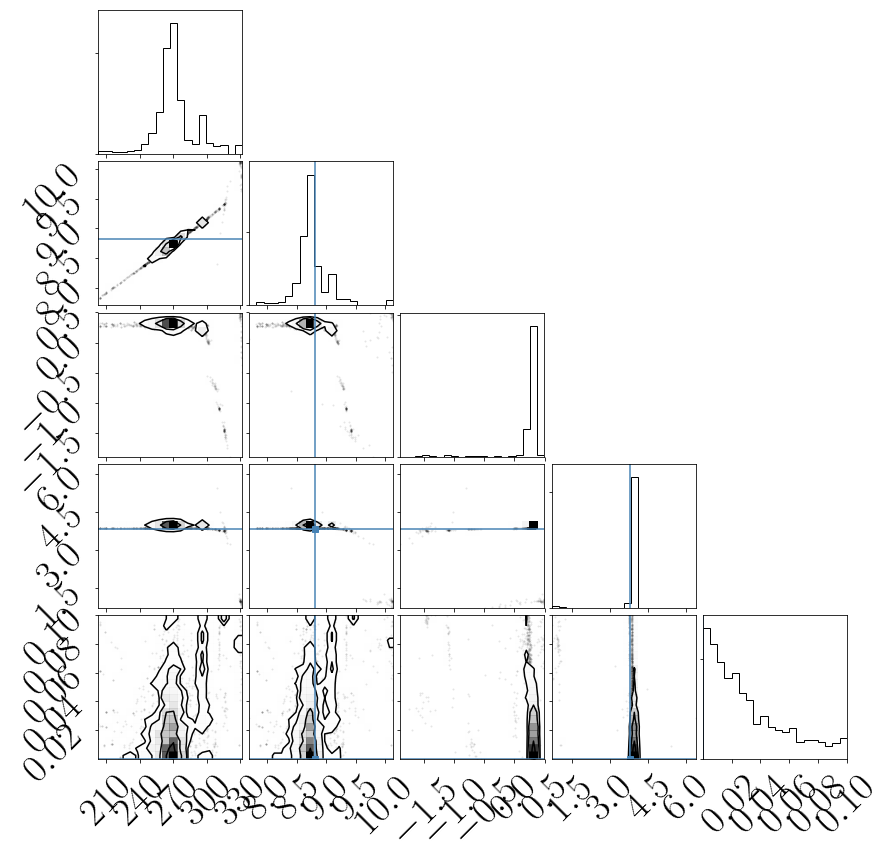

In [174]:
samples = star.samples()
print(np.shape(samples))
truths = [None, np.log10(650*1e6), 0.-7, np.log(45), 0.]
corner.corner(samples, truths=truths, quiet=True);

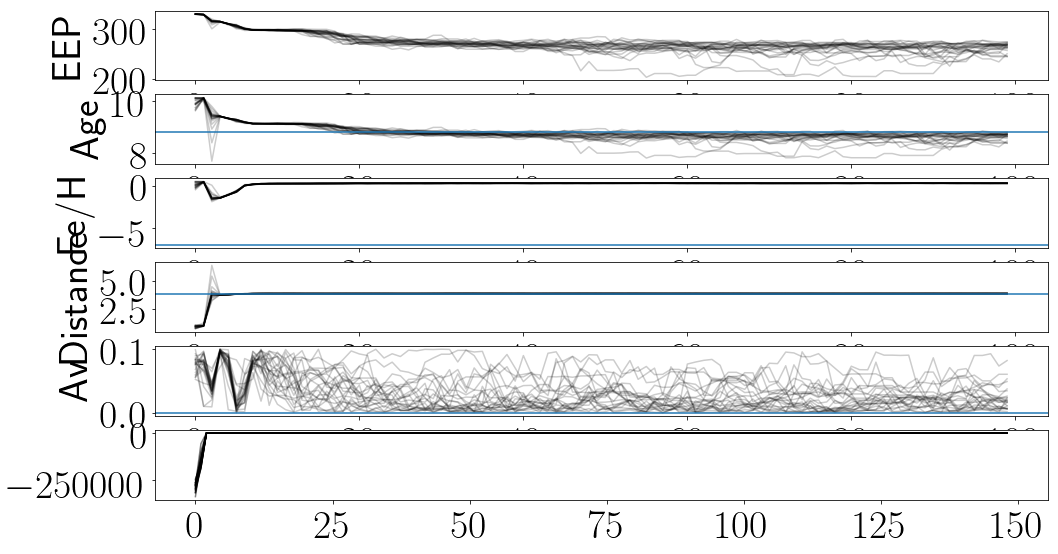

In [175]:
nwalkers, nsteps, ndim = np.shape(star.sampler.chain)
flat = np.reshape(star.sampler.chain, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(star.sampler.chain[0, 0, j])
    plt.plot(star.sampler.chain[:, :, j].T, color="k", alpha=.2);
    plt.ylabel(labels[j])
    if truths[j] is not None:
        plt.axhline(truths[j]);
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5);

In [195]:
bprp = df_singles.bp.values - df_singles.rp.values
mask = (bprp < 2) * (1 < bprp)
gyro = df_singles.iloc[mask]

In [27]:
from tools import read_files

age_samps, ages, errp, errm, std, inds = read_files("praesepe_stardate", df_singles.EPIC.values,
                                                    "hyades_results", zf=9)
bprps = df_singles.bp.values[inds] - df_singles.rp.values[inds]

age_samps_i, ages_i, errp_i, errm_i, std_i, inds_i = read_files("iso", df_singles.EPIC.values,
                                                    "hyades_results", zf=9)
print(ages_i)
bprps_i = df_singles.bp.values[inds_i] - df_singles.rp.values[inds_i]

[]


IndexError: arrays used as indices must be of integer (or boolean) type

(0, 5)

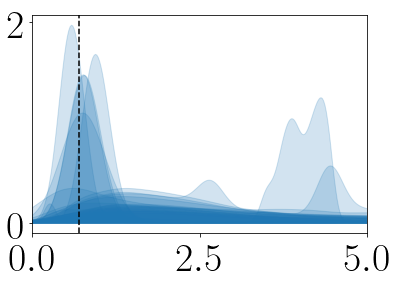

In [208]:
import scipy.stats as sps

xs = np.linspace(0, 10, 500)
for i, a in enumerate(age_samps):
    kernel = sps.gaussian_kde(a)
    plt.fill_between(xs, 0, kernel(xs), color="C0", alpha=.2, zorder=1,
                     rasterized=True)
# plt.hist(ages, 50);
plt.axvline(.7, color="k", ls="--")
plt.xlim(0, 5)

NameError: name 'bprps_i' is not defined

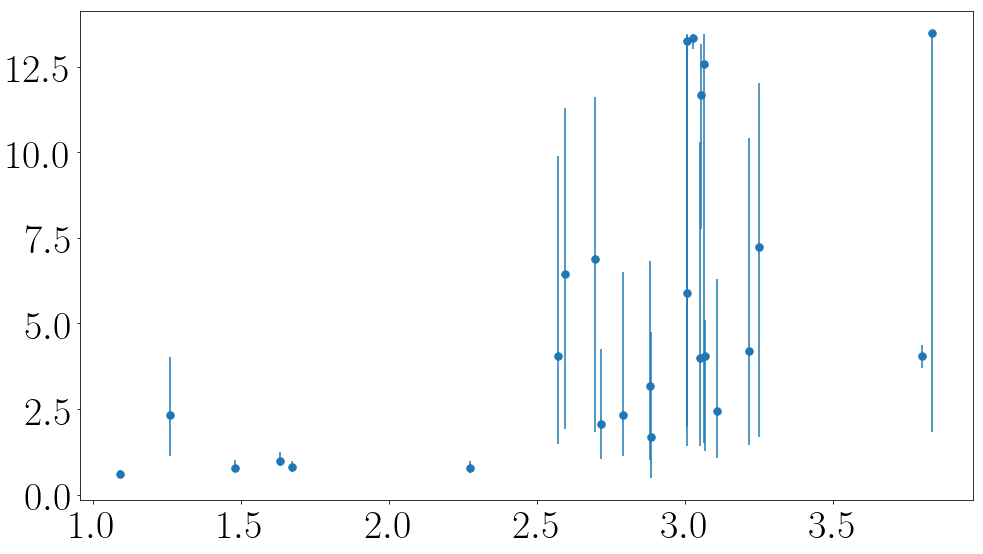

In [26]:
plt.figure(figsize=(16, 9))
plt.errorbar(bprps, ages, yerr=[errm, errp], fmt=".", ms=15)
plt.errorbar(bprps_i, ages_i, yerr=[errm_i, errp_i], fmt=".", color="C1", ms=15)
plt.axhline(.78, color=".5", ls="--", label="$\mathrm{780~Myr}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Age~[Gyr]}$")
plt.legend()

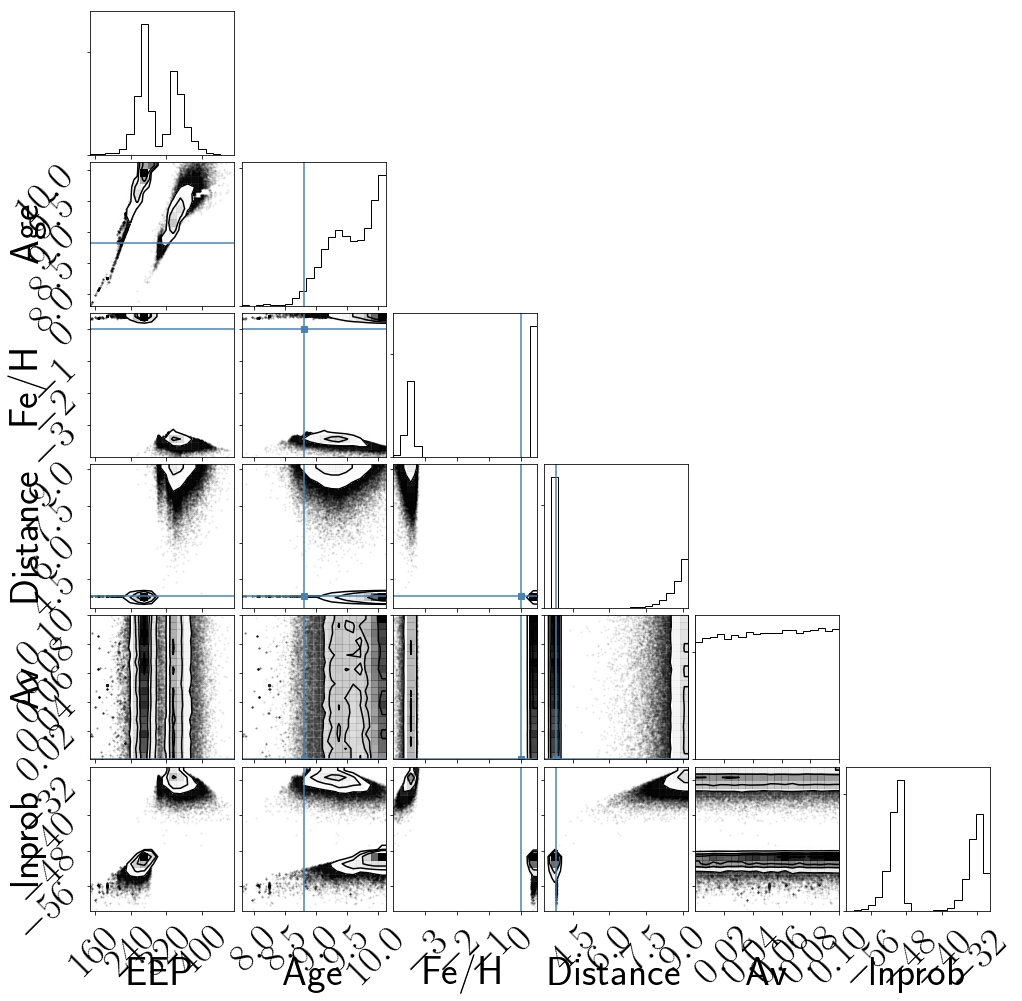

In [220]:
import emcee
import corner

i = 0
fname = "hyades_results/{}_praesepe_stardate.h5".format(df_singles.EPIC.values[i])

reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
augmented = np.zeros((nsteps, nwalkers, ndim+1))
augmented[:, :, :-1] = samples
augmented[:, :, -1] = lnprobs
nsteps, nwalkers, ndim = np.shape(augmented)
    
burnin = 100
samps = np.reshape(augmented[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
tr = [None, np.log10(650*1e6), 0., np.log(45), 0., None]

labels = ["EEP", "Age", "Fe/H", "Distance", "Av", "lnprob"]
corner.corner(samps, truths=tr, labels=labels);

[329.83150749212894, 10.07063506504619, 0.44743784954459587, 1.2611337103447202, 0.08808357433383307]


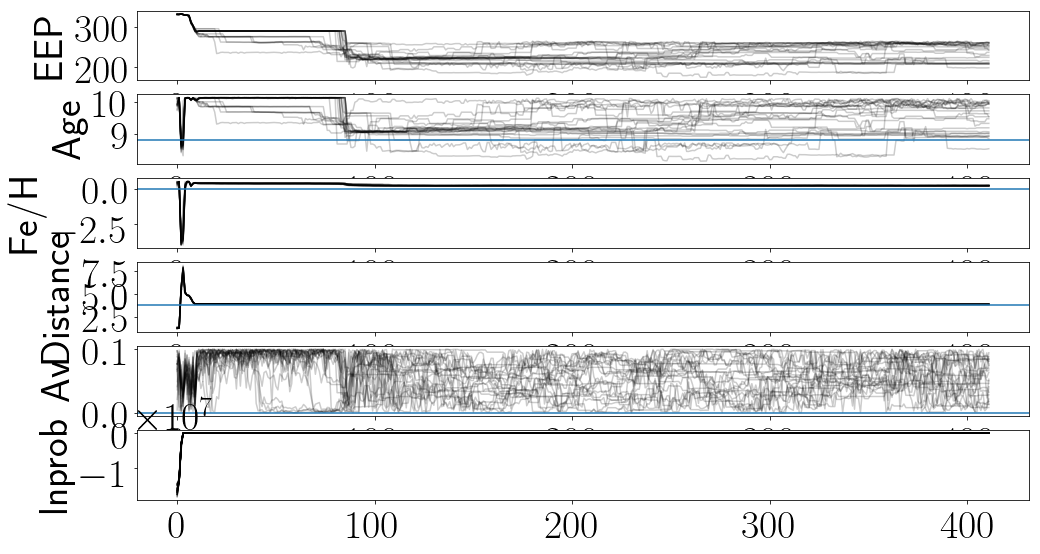

In [23]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(5):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.ylabel(labels[j])
    if tr[j] is not None:
        plt.axhline(tr[j])
plt.subplot(6, 1, 6)
plt.plot(lnprobs, "k", alpha=.5)
plt.ylabel(labels[5])
print(inits)